In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
with pd.HDFStore('train.h5','r') as train:
    df = train.get("train")

In [4]:
asset_class = df.groupby('id')
df.shape

(1710756, 111)

In [5]:
def get_corr_by_feature(df,num_features=5,min_periods=40):
    columns = df.columns
    y_values = df[columns[-1]]
    features_corr = []
    for col in columns:
        if col != 'timestamp' and col != 'id' and col != "y":
            correlation = df[col].corr(y_values,min_periods = min_periods) ##min_periods helps make sure nothing is highly correlated just because there's so little data
            features_corr.append([col,correlation])
            
    features_series = pd.DataFrame(features_corr,columns = ['Features','Correlation to Y'])
    features_series = features_series.iloc[features_series['Correlation to Y'].abs().sort_values(ascending = False).index]
    return features_series[:num_features]

We shouldn't expect asset classes to share predictive features, so let's break them up. We could try to find consistently predictive features (which several posted kernels have done) or try to create separate models for separate asset classes. The first option sounds intuitively superior for a couple reasons (computationally, + more data, etc), but since lots of people have tried that already I figured I'd try my luck at the latter.

In [6]:
##Get the top 5 most correlated features by asset class
asset_class_predictors_full = asset_class.apply(get_corr_by_feature,num_features=df.shape[1],min_periods=1)


/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


### Heatmap for absolute feature correlation to y by ID
Before we get started on building our models, it might be useful just to visualize any features that seem to be consistent. Below, you can see that a few features do seem to be generally useful, which we might include in several of models. 

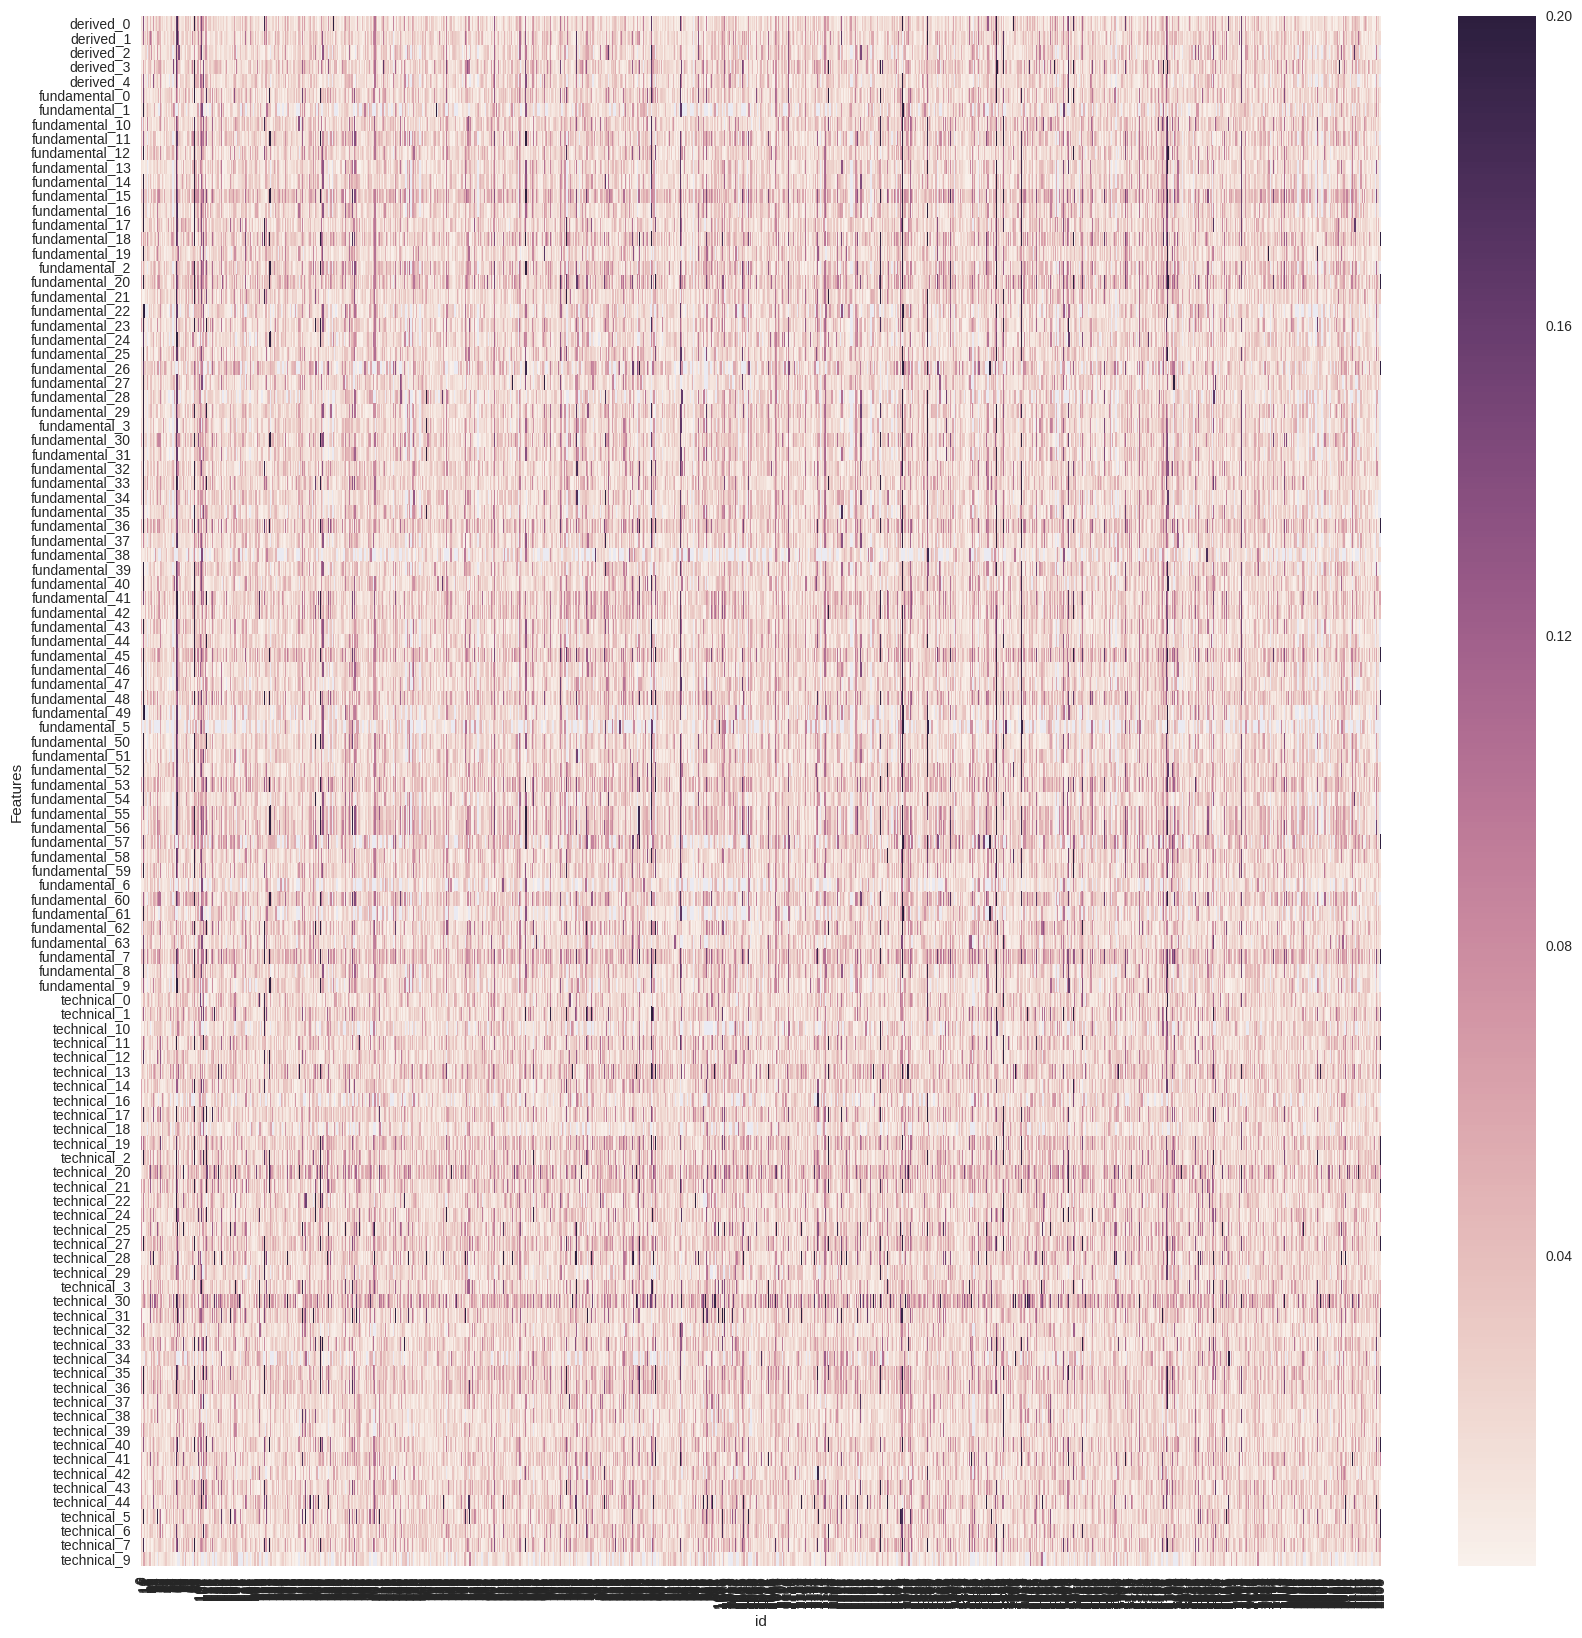

In [7]:
d = asset_class_predictors_full.reset_index().drop(['level_1'],1).sort_values(['id','Features'])
d['Correlation to Y'] = np.abs(d['Correlation to Y'])
d_pivot = d.pivot(values='Correlation to Y',index='Features',columns='id')
fig = plt.figure(figsize=(20,20))
sns.heatmap(d_pivot,vmax=0.2)


## Using Frequency to Basket Asset Classes
The goal of this kernel is to find some way to basket the asset classes in a logical way. Let's explore and see if we can't come up with a meaningful solution.

In [8]:
num_features = 5 ##We will use the top X features
min_periods = 40 ##We may change later. Helps to protect against strong correlational bias because of a tiny amount of data
maximum_correlative_features_by_class = asset_class.apply(get_corr_by_feature,num_features=num_features,min_periods=min_periods)

Let's take a look at how many times a given feature is a top 5 predictor of y given all ids.

Maximum possible value is: 1424


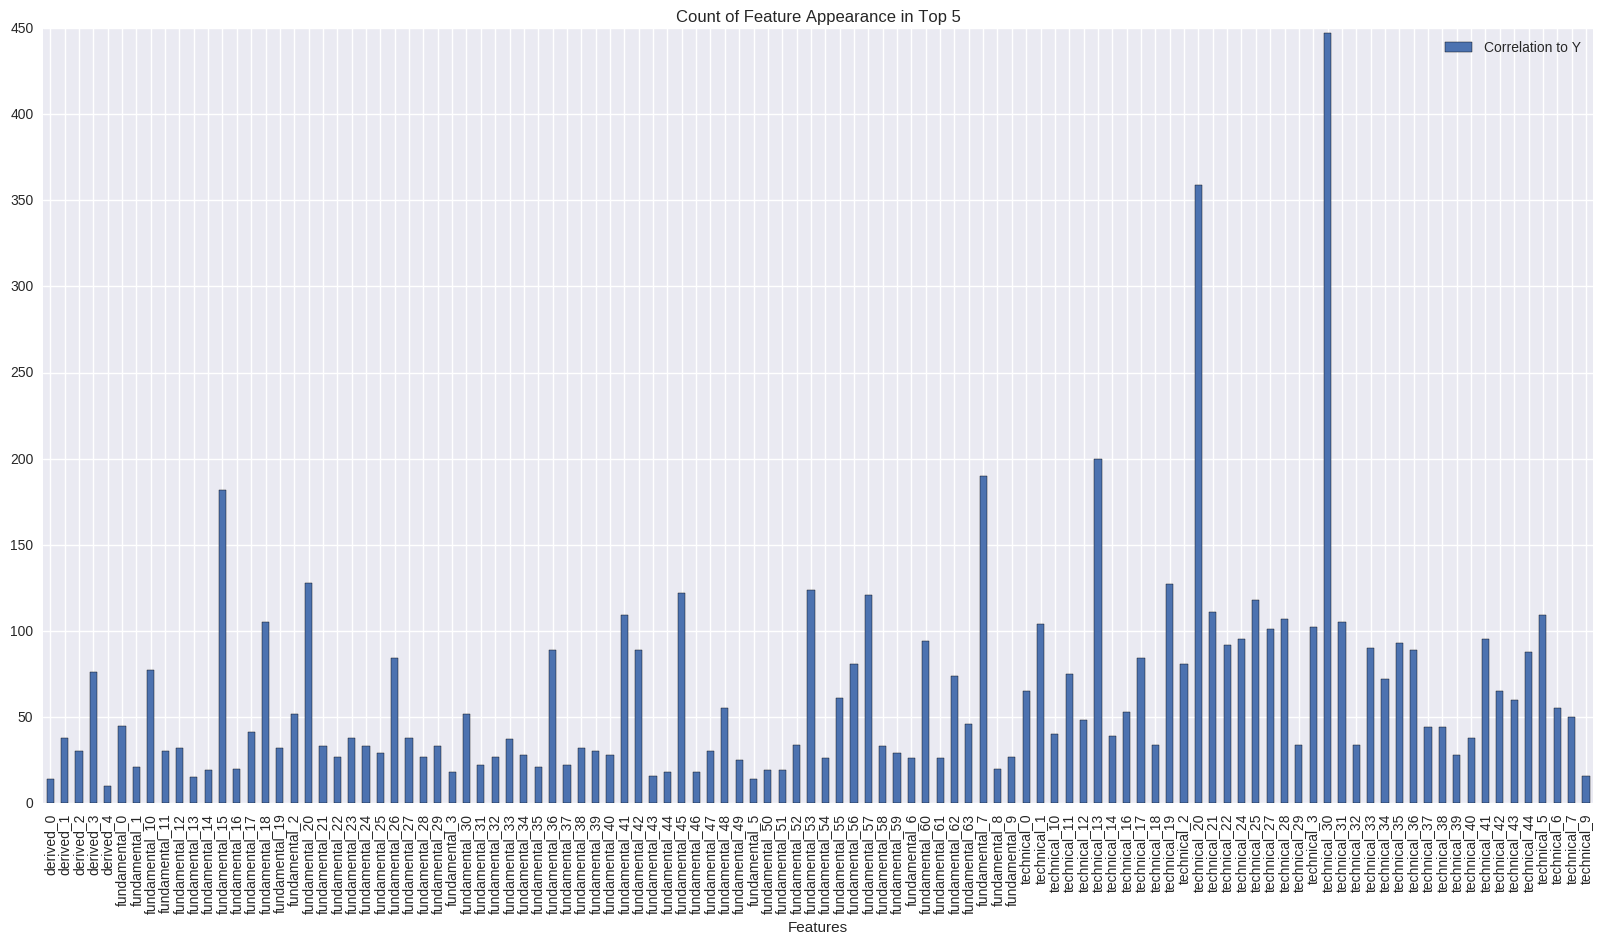

In [27]:
m = maximum_correlative_features_by_class
print("Maximum possible value is: {}".format(len(m.index.levels[0])))
feature_group = m.groupby('Features').count()
feature_group.plot(title='Count of Feature Appearance in Top 5',kind='bar',figsize=(20,10))


It's pretty clear there are a few winners. Technical 30, technical 20, technical 13, fundamental 7 and fundamental 15 have the best correlation in general and the largest overlap. 

### Find common groups of predictors

For each feature, we should see if there are other features they are frequently paired when they appear in the top 5 for correlation score. This could hint at similar asset classes.